In [789]:
from IPython.display import HTML
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR
import matplotlib.pyplot as plt
from pydfs_lineup_optimizer import get_optimizer, Site, Sport

In [790]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [791]:
file = r'C:\Users\stang\Google Drive\Data_for_fun\Fantasy Basketball\FanDuel\FanDuel-NBA-2019-02-21-32848-players-list.csv'

In [792]:
gamelogs_17 = pd.read_csv(r'C:\Users\stang\Google Drive\Data_for_fun\Fantasy Basketball\2017_18_NBA_Stats.csv')
gamelogs_17.drop(columns=['ID'], inplace=True)
gamelogs_17['BLK'].fillna(0, inplace=True)
gamelogs_17 = gamelogs_17[gamelogs_17['MP'] > 0]

In [793]:
gamelogs_18 = pd.read_csv(r'C:\Users\stang\Google Drive\Data_for_fun\Fantasy Basketball\GameLogs.csv')
gamelogs_18.drop(columns=['Unnamed: 0'], inplace=True)
gamelogs_18.rename(columns={'Unnamed: 6':'Home/Away', 'Unnamed: 8':'Result'}, inplace=True)
gamelogs_18 = gamelogs_18[gamelogs_18['MP'] > 0]

## Feature Engineering

#### General Cleanup

In [794]:
gamelogs_17.drop(columns=['Rk', 'Result', '2P', '2PA', '2P%', '3P', '3PA', '3P%', 'PF', 'FT%', 'FG%', 
                       'FG', 'FGA', 'FT', 'FTA', 'ORB', 'DRB','GmSc'], inplace=True)
gamelogs_18.drop(columns=['Rk', 'Result', '2P', '2PA', '2P%', '3P', '3PA', '3P%', 'PF', 'FT%', 'FG%', 
                       'FG', 'FGA', 'FT', 'FTA', 'ORB', 'DRB','GmSc'], inplace=True)

In [795]:
gamelogs_17['Season'] = '17/18'
gamelogs_18['Season'] = '18/19'

In [796]:
gamelogs_17['FPTS'] = gamelogs_17.TRB*1.2 + gamelogs_17.AST*1.5 + gamelogs_17.STL*3 + gamelogs_17.BLK*3 - gamelogs_17.TOV + \
                    gamelogs_17.PTS
gamelogs_18['FPTS'] = gamelogs_18.TRB*1.2 + gamelogs_18.AST*1.5 + gamelogs_18.STL*3 + gamelogs_18.BLK*3 - gamelogs_18.TOV + \
                    gamelogs_18.PTS
gamelogs_18 = gamelogs_18[gamelogs_18['FPTS']>0]
gamelogs_17 = gamelogs_17[gamelogs_17['FPTS']>0]
gamelogs_17['log_FPTS'] = np.log(gamelogs_17['FPTS'])
gamelogs_18['log_FPTS'] = np.log(gamelogs_18['FPTS'])

In [797]:
gamelogs_17.drop_duplicates(keep='first', inplace=True)
gamelogs_18.drop_duplicates(keep='first', inplace=True)

#### Game Number

In [798]:
gamelogs_17['Date'] = pd.to_datetime(gamelogs_17['Date'])
gamelogs_17['Game_Num'] = gamelogs_17.sort_values(by=['Player','Date']).groupby('Player').cumcount() + 1

In [799]:
gamelogs_18['Date'] = pd.to_datetime(gamelogs_18['Date'])
gamelogs_18['Game_Num'] = gamelogs_18.sort_values(by=['Player','Date']).groupby('Player').cumcount() + 1

#### Previous Game Variables (Fantasy Points, Minutes Played, Start)

In [800]:
gamelogs_17['PV_MP'] = gamelogs_17.sort_values(['Player','Date']).groupby('Player')['MP'].shift(1)
gamelogs_17['PV_FPTS'] = gamelogs_17.sort_values(['Player','Date']).groupby('Player')['FPTS'].shift(1)
gamelogs_17['PV_GS'] = gamelogs_17.sort_values(['Player','Date']).groupby('Player')['GS'].shift(1)


gamelogs_17['PV_MP_2'] = gamelogs_17.sort_values(['Player','Date']).groupby('Player')['MP'].shift(2)
gamelogs_17['PV_FPTS_2'] = gamelogs_17.sort_values(['Player','Date']).groupby('Player')['FPTS'].shift(2)

In [801]:
gamelogs_18['PV_MP'] = gamelogs_18.sort_values(['Player','Date']).groupby('Player')['MP'].shift(1)
gamelogs_18['PV_FPTS'] = gamelogs_18.sort_values(['Player','Date']).groupby('Player')['FPTS'].shift(1)
gamelogs_18['PV_GS'] = gamelogs_18.sort_values(['Player','Date']).groupby('Player')['GS'].shift(1)


gamelogs_18['PV_MP_2'] = gamelogs_18.sort_values(['Player','Date']).groupby('Player')['MP'].shift(2)
gamelogs_18['PV_FPTS_2'] = gamelogs_18.sort_values(['Player','Date']).groupby('Player')['FPTS'].shift(2)

#### Season Averages - Rolling Average (Fantasy Points, Minutes Played)

In [802]:
gamelogs_17['AVG_FPTS'] = gamelogs_17.sort_values(by=['Player','Date']).groupby('Player')['PV_FPTS'] \
                            .transform(lambda x: x.expanding().mean())
gamelogs_17['Std_FPTS'] = gamelogs_17.sort_values(by=['Player','Date']).groupby('Player')['PV_FPTS'] \
                            .transform(lambda x: x.expanding().std())
gamelogs_17['AVG_MP'] = gamelogs_17.sort_values(by=['Player','Date']).groupby('Player')['PV_MP'] \
                            .transform(lambda x: x.expanding().mean())

In [803]:
gamelogs_18['AVG_FPTS'] = gamelogs_18.sort_values(by=['Player','Date']).groupby('Player')['PV_FPTS'] \
                            .transform(lambda x: x.expanding().mean())
gamelogs_18['Std_FPTS'] = gamelogs_18.sort_values(by=['Player','Date']).groupby('Player')['PV_FPTS'] \
                            .transform(lambda x: x.expanding().std())
gamelogs_18['AVG_MP'] = gamelogs_18.sort_values(by=['Player','Date']).groupby('Player')['PV_MP'] \
                            .transform(lambda x: x.expanding().mean())

#### Last 3 Games Played (Fantasy Points, Minutes Played)

In [804]:
gamelogs_17['AVG_FPTS_3'] = gamelogs_17.sort_values(by=['Player','Date']).groupby('Player')['PV_FPTS'] \
                            .rolling(3).mean().reset_index(0,drop=True)
gamelogs_17['Std_FPTS_3'] = gamelogs_17.sort_values(by=['Player','Date']).groupby('Player')['PV_FPTS'] \
                            .rolling(3).std().reset_index(0,drop=True)
gamelogs_17['AVG_MP_3'] = gamelogs_17.sort_values(by=['Player','Date']).groupby('Player')['PV_MP'] \
                            .rolling(3).mean().reset_index(0,drop=True)

In [805]:
gamelogs_18['AVG_FPTS_3'] = gamelogs_18.sort_values(by=['Player','Date']).groupby('Player')['PV_FPTS'] \
                            .rolling(3).mean().reset_index(0,drop=True)
gamelogs_18['Std_FPTS_3'] = gamelogs_18.sort_values(by=['Player','Date']).groupby('Player')['PV_FPTS'] \
                            .rolling(3).std().reset_index(0,drop=True)
gamelogs_18['AVG_MP_3'] = gamelogs_18.sort_values(by=['Player','Date']).groupby('Player')['PV_MP'] \
                            .rolling(3).mean().reset_index(0,drop=True)

#### Last 2 Games Played (Fantasy Points, Minutes Played)

In [806]:
gamelogs_17['AVG_FPTS_2'] = gamelogs_17.sort_values(by=['Player','Date']).groupby('Player')['PV_FPTS'] \
                            .rolling(2).mean().reset_index(0,drop=True)
gamelogs_17['Std_FPTS_2'] = gamelogs_17.sort_values(by=['Player','Date']).groupby('Player')['PV_FPTS'] \
                            .rolling(2).std().reset_index(0,drop=True)
gamelogs_17['AVG_MP_2'] = gamelogs_17.sort_values(by=['Player','Date']).groupby('Player')['PV_MP'] \
                            .rolling(2).mean().reset_index(0,drop=True)

In [807]:
gamelogs_18['AVG_FPTS_2'] = gamelogs_18.sort_values(by=['Player','Date']).groupby('Player')['PV_FPTS'] \
                            .rolling(2).mean().reset_index(0,drop=True)
gamelogs_18['Std_FPTS_2'] = gamelogs_18.sort_values(by=['Player','Date']).groupby('Player')['PV_FPTS'] \
                            .rolling(2).std().reset_index(0,drop=True)
gamelogs_18['AVG_MP_2'] = gamelogs_18.sort_values(by=['Player','Date']).groupby('Player')['PV_MP'] \
                            .rolling(2).mean().reset_index(0,drop=True)

#### Position (Average, Standard Deviation)

In [808]:
gamelogs_17 = gamelogs_17[~gamelogs_17['Pos'].isnull()]
gamelogs_18 = gamelogs_18[~gamelogs_18['Pos'].isnull()]

In [809]:
pos_17 = gamelogs_17.loc[:,['Pos', 'Date', 'FPTS']]
pos_17 = pos_17.groupby(['Pos', 'Date']).median()['FPTS'].reset_index()
pos_17['PV_FPTS'] = pos_17.sort_values(['Pos','Date']).groupby('Pos')['FPTS'].shift(1)
pos_17['POS_AVG_FPTS'] = pos_17.sort_values(by=['Pos','Date']).groupby('Pos')['PV_FPTS'] \
                            .transform(lambda x: x.expanding().mean())
pos_17.drop(columns=['FPTS', 'PV_FPTS'], inplace=True)

In [810]:
pos_17 = gamelogs_17.loc[:,['Pos', 'Date', 'FPTS']]
pos_17 = pos_17.groupby(['Pos', 'Date']).median()['FPTS'].reset_index()
pos_17['PV_FPTS'] = pos_17.sort_values(['Pos','Date']).groupby('Pos')['FPTS'].shift(1)
pos_17['POS_AVG_FPTS'] = pos_17.sort_values(by=['Pos','Date']).groupby('Pos')['PV_FPTS'] \
                            .transform(lambda x: x.expanding().mean())
pos_17.drop(columns=['FPTS', 'PV_FPTS'], inplace=True)

In [811]:
gamelogs_17v = pd.merge(gamelogs_17, pos_17, how='left', on=['Pos', 'Date'])
gamelogs_17 = gamelogs_17v

In [812]:
pos_18 = gamelogs_18.loc[:,['Pos', 'Date', 'FPTS']]
pos_18 = pos_18.groupby(['Pos', 'Date']).median()['FPTS'].reset_index()
pos_18['PV_FPTS'] = pos_18.sort_values(['Pos','Date']).groupby('Pos')['FPTS'].shift(1)
pos_18['POS_AVG_FPTS'] = pos_18.sort_values(by=['Pos','Date']).groupby('Pos')['PV_FPTS'] \
                            .transform(lambda x: x.expanding().mean())
pos_18.drop(columns=['FPTS', 'PV_FPTS'], inplace=True)

In [813]:
gamelogs_18v = pd.merge(gamelogs_18, pos_18, how='left', on=['Pos', 'Date'])
gamelogs_18 = gamelogs_18v

#### Opponent Season Fantasy Points Allowed by Position

In [814]:
opp_17 = gamelogs_17.loc[:,['Opp', 'Pos', 'Date', 'FPTS']]
opp_17 = opp_17.groupby(['Opp', 'Pos', 'Date']).median()['FPTS'].reset_index()
opp_17['PV_FPTS'] = opp_17.sort_values(['Opp', 'Pos','Date']).groupby(['Opp', 'Pos'])['FPTS'].shift(1)
opp_17['Opp_AVG_FPTS'] = opp_17.sort_values(by=['Opp', 'Pos','Date']).groupby(['Opp', 'Pos'])['PV_FPTS'] \
                            .transform(lambda x: x.expanding().mean())
opp_17.drop(columns=['FPTS', 'PV_FPTS'], inplace=True)

In [815]:
gamelogs_17x = pd.merge(gamelogs_17, opp_17, how='left', on=['Opp', 'Pos', 'Date'])
gamelogs_17 = gamelogs_17x

In [816]:
opp_18 = gamelogs_18.loc[:,['Opp', 'Pos', 'Date', 'FPTS']]
opp_18 = opp_18.groupby(['Opp', 'Pos', 'Date']).median()['FPTS'].reset_index()
opp_18['PV_FPTS'] = opp_18.sort_values(['Opp', 'Pos','Date']).groupby(['Opp', 'Pos'])['FPTS'].shift(1)
opp_18['Opp_AVG_FPTS'] = opp_18.sort_values(by=['Opp', 'Pos','Date']).groupby(['Opp', 'Pos'])['PV_FPTS'] \
                            .transform(lambda x: x.expanding().mean())
opp_18.drop(columns=['FPTS', 'PV_FPTS'], inplace=True)

In [817]:
gamelogs_18x = pd.merge(gamelogs_18, opp_18, how='left', on=['Opp', 'Pos', 'Date'])
gamelogs_18 = gamelogs_18x

#### Days of Rest

In [818]:
gamelogs_17['Rest'] = gamelogs_17.sort_values(['Player','Date']).groupby('Player')['Date'].diff().dt.days - 1
# All Star Break
gamelogs_17['Rest'] = np.where((gamelogs_17['Rest'] > 6) & 
                               ((gamelogs_17['Date'] < '2018-02-16') | (gamelogs_17['Date'] > '2018-02-22')), 
                                                        np.NaN, gamelogs_17['Rest'])
latest_17 = gamelogs_17.loc[gamelogs_17.groupby('Player').Date.idxmax()]
gamelogs_17 = pd.concat([gamelogs_17, latest_17], ignore_index=True)
gamelogs_17.drop_duplicates(keep=False, inplace=True)
gamelogs_17['Rest'].fillna((gamelogs_17['Rest'].mean()), inplace=True)
gamelogs_17 = pd.concat([gamelogs_17, latest_17], ignore_index=True)

In [819]:
gamelogs_18['Rest'] = gamelogs_18.sort_values(['Player','Date']).groupby('Player')['Date'].diff().dt.days - 1
# All Star Break

In [820]:
gamelogs_18['Rest'] = np.where((gamelogs_18['Rest'] > 6) & 
                               ((gamelogs_18['Date'] < '2019-02-15') | (gamelogs_18['Date'] > '2019-02-23')), 
                                                        np.NaN, gamelogs_18['Rest'])
latest_18 = gamelogs_18.loc[gamelogs_18.groupby('Player').Date.idxmax()]
gamelogs_18 = pd.concat([gamelogs_18, latest_18], ignore_index=True)
gamelogs_18.drop_duplicates(keep=False, inplace=True)
gamelogs_18['Rest'].fillna((gamelogs_18['Rest'].mean()), inplace=True)
gamelogs_18 = pd.concat([gamelogs_18, latest_18], ignore_index=True)

#### Injury Status

In [821]:
gamelogs_17['After_Injury'] = np.where(round(gamelogs_17['Rest'], 5) == round(gamelogs_17['Rest'].mean(), 5), 1, 0)

In [822]:
gamelogs_18['After_Injury'] = np.where(round(gamelogs_18['Rest'], 5) == round(gamelogs_17['Rest'].mean(), 5), 1, 0)

#### Concatenate Seasons Together

In [823]:
gamelogs = pd.concat([gamelogs_17, gamelogs_18], ignore_index=True)

#### Age

In [824]:
new = gamelogs['Age'].str.split("-", n = 1, expand = True) 

In [825]:
gamelogs['Years'] = new[0].astype(float)
gamelogs['Days'] = new[1].astype(float)
gamelogs['Age'] = gamelogs['Years'] + gamelogs['Days']/365
gamelogs.drop(columns=['Years', 'Days'], inplace=True)

In [826]:
gamelogs['Age_sq'] = gamelogs['Age']**2

#### Home/Away

In [827]:
gamelogs['Home/Away'] = np.where(gamelogs['Home/Away']  == '@', 0, 1).astype(int)

#### Verification

In [828]:
gamelogs[gamelogs.Game_Num > 3].sort_values(by='Date', ascending=False).head()

,Player,Age,Pos,Date,Tm,Home/Away,Opp,GS,MP,TRB,...,Std_FPTS_3,AVG_MP_3,AVG_FPTS_2,Std_FPTS_2,AVG_MP_2,POS_AVG_FPTS,Opp_AVG_FPTS,Rest,After_Injury,Age_sq
42310,Evan Fournier,26.295890,G-F,2019-02-14,ORL,1,CHO,1,27,3,...,6.148984,33.666667,33.15,0.070711,34.5,17.245763,21.371212,1.0,0,691.473853
42404,John Jenkins,27.945205,G,2019-02-14,NYK,0,ATL,0,26,5,...,2.750152,6.666667,5.75,3.889087,8.0,19.434746,22.537719,2.0,0,780.934509
42297,E'Twaun Moore,29.969863,G,2019-02-14,NOP,1,OKC,0,17,1,...,10.887148,20.333333,14.75,14.637110,21.0,19.434746,21.094545,1.0,0,898.192689
42597,Taurean Waller-Prince,24.901370,F,2019-02-14,ATL,1,NYK,1,29,5,...,9.662815,26.666667,25.20,4.949747,26.5,19.109322,21.760000,1.0,0,620.078221
42598,Terrance Ferguson,20.747945,G-F,2019-02-14,OKC,0,NOP,1,36,2,...,6.864644,30.666667,17.65,9.404520,32.0,17.245763,18.556250,2.0,0,430.477230


In [829]:
gamelogs[gamelogs['FPTS'].isnull()]

,Player,Age,Pos,Date,Tm,Home/Away,Opp,GS,MP,TRB,...,Std_FPTS_3,AVG_MP_3,AVG_FPTS_2,Std_FPTS_2,AVG_MP_2,POS_AVG_FPTS,Opp_AVG_FPTS,Rest,After_Injury,Age_sq


### Visualize the Data

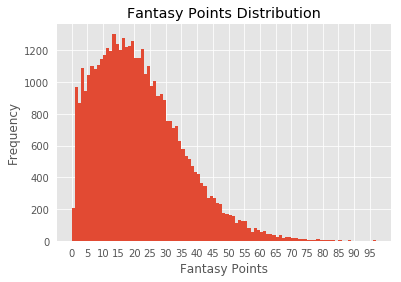

In [830]:
bins = [x for x in range(np.max(gamelogs['FPTS']).round(0).astype(int))]
plt.hist(gamelogs['FPTS'], bins, histtype="bar")
plt.style.use("ggplot")
xt = [x for x in range(0, np.max(gamelogs['FPTS']).round(0).astype(int), 5)]
plt.xticks(xt, xt)
plt.tick_params(bottom=False, left=False)
plt.ylabel("Frequency")
plt.xlabel("Fantasy Points")
plt.title("Fantasy Points Distribution")
plt.show()

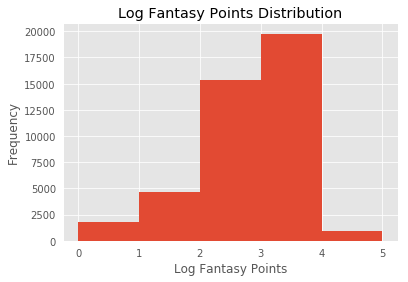

In [831]:
bins = [x for x in range(6)]
plt.hist(np.log(gamelogs['FPTS']), bins, histtype="bar")
plt.style.use("ggplot")
xt = [x for x in range(0, 6, 1)]
plt.xticks(xt, xt)
plt.tick_params(bottom=False, left=False)
plt.ylabel("Frequency")
plt.xlabel("Log Fantasy Points")
plt.title("Log Fantasy Points Distribution")
plt.show()

## Model Building

In [832]:
model = gamelogs.loc[:, ['Player', 'Date', 'Game_Num','Pos', 'GS', 'log_FPTS', 'FPTS','Age', 'Age_sq','PV_FPTS', 'PV_MP',
                         'AVG_MP_2','Home/Away', 'PV_GS', 'AVG_FPTS', 'Std_FPTS','PV_FPTS_2','PV_MP_2','AVG_FPTS_2', 
                         'Std_FPTS_2', 'AVG_MP', 'AVG_FPTS_3', 'Std_FPTS_3', 'AVG_MP_3', 'POS_AVG_FPTS', 'Opp_AVG_FPTS', 
                         'Rest', 'After_Injury']]

# 

In [833]:
model.shape

(42658, 28)

In [834]:
model.isnull().sum(axis=0)

Player             0
Date               0
Game_Num           0
Pos                0
GS                 0
log_FPTS           0
FPTS               0
Age                3
Age_sq             3
PV_FPTS         1032
PV_MP           1032
AVG_MP_2        2026
Home/Away          0
PV_GS           1032
AVG_FPTS        1032
Std_FPTS        2026
PV_FPTS_2       2026
PV_MP_2         2026
AVG_FPTS_2      2026
Std_FPTS_2      2026
AVG_MP          1032
AVG_FPTS_3      3004
Std_FPTS_3      3004
AVG_MP_3        3004
POS_AVG_FPTS      81
Opp_AVG_FPTS     805
Rest             137
After_Injury       0
dtype: int64

In [835]:
model.dropna(inplace=True)

In [836]:
model.shape

(39524, 28)

In [837]:
model.head()

,Player,Date,Game_Num,Pos,GS,log_FPTS,FPTS,Age,Age_sq,PV_FPTS,...,AVG_FPTS_2,Std_FPTS_2,AVG_MP,AVG_FPTS_3,Std_FPTS_3,AVG_MP_3,POS_AVG_FPTS,Opp_AVG_FPTS,Rest,After_Injury
845,Ryan Anderson,2017-10-23,4,F,1,2.721295,15.2,29.465753,868.230625,16.5,...,16.25,0.353553,27.333333,20.866667,8.000208,27.333333,18.308333,16.550000,1.0,0
848,Trevor Ariza,2017-10-23,4,F,1,2.833213,17.0,32.315068,1044.263652,28.3,...,17.85,14.778532,33.666667,21.133333,11.897199,33.666667,18.308333,16.550000,1.0,0
849,Luke Babbitt,2017-10-23,4,F,0,2.219203,9.2,28.342466,803.295365,1.4,...,5.80,6.222540,10.333333,5.933333,4.406056,10.333333,18.308333,26.775000,0.0,0
851,J.J. Barea,2017-10-23,4,G,0,3.202746,24.6,33.326027,1110.624102,26.5,...,28.35,2.616295,22.333333,26.933333,3.073001,22.333333,20.233333,27.116667,1.0,0
852,Harrison Barnes,2017-10-23,4,F,1,3.328627,27.9,25.400000,645.160000,23.0,...,26.15,4.454773,36.000000,26.733333,3.308071,36.000000,18.308333,20.250000,1.0,0


In [838]:
model.columns

Index(['Player', 'Date', 'Game_Num', 'Pos', 'GS', 'log_FPTS', 'FPTS', 'Age',
       'Age_sq', 'PV_FPTS', 'PV_MP', 'AVG_MP_2', 'Home/Away', 'PV_GS',
       'AVG_FPTS', 'Std_FPTS', 'PV_FPTS_2', 'PV_MP_2', 'AVG_FPTS_2',
       'Std_FPTS_2', 'AVG_MP', 'AVG_FPTS_3', 'Std_FPTS_3', 'AVG_MP_3',
       'POS_AVG_FPTS', 'Opp_AVG_FPTS', 'Rest', 'After_Injury'],
      dtype='object')

In [839]:
corr = model.corr()
corr.style.background_gradient().set_precision(2)

C:\Users\stang\Documents\Continuum\Anaconda\lib\site-packages\matplotlib\colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


,Game_Num,GS,log_FPTS,FPTS,Age,Age_sq,PV_FPTS,PV_MP,AVG_MP_2,Home/Away,PV_GS,AVG_FPTS,Std_FPTS,PV_FPTS_2,PV_MP_2,AVG_FPTS_2,Std_FPTS_2,AVG_MP,AVG_FPTS_3,Std_FPTS_3,AVG_MP_3,POS_AVG_FPTS,Opp_AVG_FPTS,Rest,After_Injury
Game_Num,1,0.15,0.17,0.15,0.053,0.05,0.16,0.2,0.22,0.0062,0.15,0.18,0.24,0.16,0.2,0.18,0.055,0.25,0.18,0.074,0.23,-0.029,0.029,-0.05,nan
GS,0.15,1,0.48,0.51,0.013,0.0053,0.5,0.61,0.65,-0.0012,0.87,0.6,0.37,0.49,0.59,0.55,0.15,0.66,0.58,0.2,0.67,0.11,0.061,-0.075,nan
log_FPTS,0.17,0.48,1,0.87,0.027,0.018,0.51,0.54,0.57,0.012,0.45,0.61,0.42,0.5,0.52,0.57,0.18,0.58,0.59,0.23,0.58,0.11,0.073,-0.092,nan
FPTS,0.15,0.51,0.87,1,0.0047,-0.0048,0.59,0.54,0.58,0.021,0.48,0.71,0.46,0.58,0.53,0.65,0.19,0.61,0.68,0.25,0.59,0.15,0.099,-0.07,nan
Age,0.053,0.013,0.027,0.0047,1,1,0.0075,0.023,0.027,0.0062,0.017,0.043,-0.06,0.0093,0.026,0.0094,-0.0086,0.07,0.011,-0.014,0.03,0.01,0.024,0.002,nan
Age_sq,0.05,0.0053,0.018,-0.0048,1,1,-0.0022,0.012,0.014,0.0061,0.0086,0.029,-0.067,-0.00049,0.015,-0.0015,-0.011,0.055,-0.0002,-0.017,0.017,0.0053,0.021,0.0038,nan
PV_FPTS,0.16,0.5,0.51,0.59,0.0075,-0.0022,1,0.76,0.71,-0.00077,0.51,0.75,0.5,0.59,0.54,0.89,0.27,0.63,0.85,0.33,0.69,0.16,0.088,-0.089,nan
PV_MP,0.2,0.61,0.54,0.54,0.023,0.012,0.76,1,0.92,0.00087,0.64,0.67,0.44,0.56,0.7,0.74,0.21,0.78,0.73,0.27,0.89,0.061,0.0055,-0.13,nan
AVG_MP_2,0.22,0.65,0.57,0.58,0.027,0.014,0.71,0.92,1,0.0046,0.68,0.73,0.48,0.72,0.92,0.8,0.22,0.85,0.79,0.29,0.97,0.066,0.0051,-0.12,nan
Home/Away,0.0062,-0.0012,0.012,0.021,0.0062,0.0061,-0.00077,0.00087,0.0046,1,0.0047,0.0033,0.0015,0.0018,0.0077,0.00059,0.0024,0.0054,0.00096,0.0063,0.0056,0.0002,0.001,0.047,nan


In [840]:
X = model.loc[:, ['Age', 'Age_sq','PV_FPTS', 'PV_MP','Home/Away',
                         'PV_GS', 'AVG_FPTS', 'Std_FPTS', 'Std_FPTS_2',
                         'AVG_FPTS_3', 'Std_FPTS_3', 'AVG_MP_3', 'POS_AVG_FPTS', 'Opp_AVG_FPTS', 'Rest', 'After_Injury']]
y = model.FPTS

X.columns

# 'PV_FPTS_2','PV_MP_2','AVG_FPTS_2', 'AVG_MP_2', 'AVG_MP',

Index(['Age', 'Age_sq', 'PV_FPTS', 'PV_MP', 'Home/Away', 'PV_GS', 'AVG_FPTS',
       'Std_FPTS', 'Std_FPTS_2', 'AVG_FPTS_3', 'Std_FPTS_3', 'AVG_MP_3',
       'POS_AVG_FPTS', 'Opp_AVG_FPTS', 'Rest', 'After_Injury'],
      dtype='object')

In [841]:
model.to_csv("dataset.csv")

In [842]:
model.head()

,Player,Date,Game_Num,Pos,GS,log_FPTS,FPTS,Age,Age_sq,PV_FPTS,...,AVG_FPTS_2,Std_FPTS_2,AVG_MP,AVG_FPTS_3,Std_FPTS_3,AVG_MP_3,POS_AVG_FPTS,Opp_AVG_FPTS,Rest,After_Injury
845,Ryan Anderson,2017-10-23,4,F,1,2.721295,15.2,29.465753,868.230625,16.5,...,16.25,0.353553,27.333333,20.866667,8.000208,27.333333,18.308333,16.550000,1.0,0
848,Trevor Ariza,2017-10-23,4,F,1,2.833213,17.0,32.315068,1044.263652,28.3,...,17.85,14.778532,33.666667,21.133333,11.897199,33.666667,18.308333,16.550000,1.0,0
849,Luke Babbitt,2017-10-23,4,F,0,2.219203,9.2,28.342466,803.295365,1.4,...,5.80,6.222540,10.333333,5.933333,4.406056,10.333333,18.308333,26.775000,0.0,0
851,J.J. Barea,2017-10-23,4,G,0,3.202746,24.6,33.326027,1110.624102,26.5,...,28.35,2.616295,22.333333,26.933333,3.073001,22.333333,20.233333,27.116667,1.0,0
852,Harrison Barnes,2017-10-23,4,F,1,3.328627,27.9,25.400000,645.160000,23.0,...,26.15,4.454773,36.000000,26.733333,3.308071,36.000000,18.308333,20.250000,1.0,0


#### Normalization and Train/Test Split

In [843]:
x_scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_scale = x_scaler.fit_transform(X_train)
X_test_scale = x_scaler.transform(X_test)

print("X shape:", X_train.shape, X_test.shape)
print("y shape:", y_train.size, y_test.size)
print("Verify Fixed State:", y_train.mean(), y_test.mean())

X shape: (31619, 16) (7905, 16)
y shape: 31619 7905
Verify Fixed State: 21.805670641070236 21.923048703352393


#### Set up Nested CV

In [844]:
inner_cv = KFold(n_splits=4, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=0)

#### Linear Regression

In [845]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scale, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [846]:
print('Intercept: \n', lin_reg.intercept_)
print('Coefficients: \n', lin_reg.coef_)
print('Test Data R2: {:.5f}'.format(lin_reg.score(X_test_scale, y_test)))

Intercept: 
 21.805670641070243
Coefficients: 
 [-0.62492555  0.3727941  -0.06558423  0.987576    0.31759567  0.67051263
  6.97715691  0.07033729  0.15737883  2.43505786 -0.09431205 -0.52906977
 -0.06001582  0.33706317 -0.1328783   0.        ]
Test Data R2: 0.51157


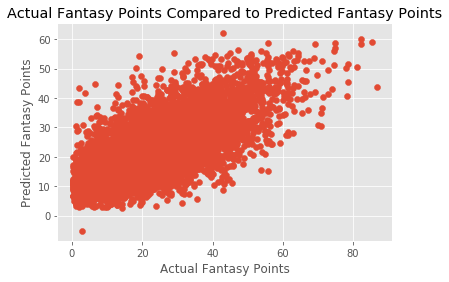

In [847]:
plt.scatter(y_test, lin_reg.predict(X_test_scale))
plt.xlabel('Actual Fantasy Points')
plt.ylabel('Predicted Fantasy Points')
plt.title("Actual Fantasy Points Compared to Predicted Fantasy Points")
plt.show()

#### Lasso Regression

In [848]:
lassocv = LassoCV()
lassocv.fit(X_train_scale, y_train)
lassocv_score = lassocv.score(X_test_scale, y_test)
lassocv_alpha = lassocv.alpha_
print('Intercept:', lassocv.intercept_)
print('Coefficients: \n', lassocv.coef_)
print('Variance score: %.5f' %lassocv_score)
print('Alpha:  %.2f' %lassocv.alpha_)

Intercept: 21.805670641070243
Coefficients: 
 [-2.44914523e-01 -0.00000000e+00  4.17426902e-03  8.58154503e-01
  3.06507006e-01  6.47817993e-01  6.96152729e+00  5.74060544e-02
  1.20961024e-01  2.32843447e+00 -4.55018247e-02 -3.43091504e-01
 -2.75596482e-02  3.13832618e-01 -1.20901993e-01  0.00000000e+00]
Variance score: 0.51174
Alpha:  0.01


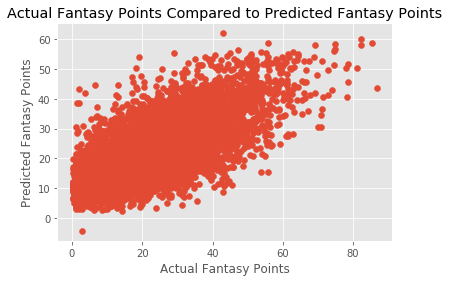

In [849]:
plt.scatter(y_test, lassocv.predict(X_test_scale))
plt.xlabel('Actual Fantasy Points')
plt.ylabel('Predicted Fantasy Points')
plt.title("Actual Fantasy Points Compared to Predicted Fantasy Points")
plt.show()

#### Ridge Regression

In [850]:
ridgecv = RidgeCV()
ridgecv.fit(X_train_scale, y_train)
ridgecv_score = ridgecv.score(X_test_scale, y_test)
print('Intercept:', ridgecv.intercept_)
print('Coefficients: \n', ridgecv.coef_)
print('Variance score: %.5f' % ridgecv_score)
print('Alpha:  %.2f' %ridgecv.alpha_)

Intercept: 21.805670641070243
Coefficients: 
 [-0.59060962  0.33892705 -0.05974619  0.98117738  0.31747802  0.67123714
  6.96722411  0.07256756  0.15703842  2.43386974 -0.09441011 -0.52069872
 -0.05921736  0.33684935 -0.13274434  0.        ]
Variance score: 0.51159
Alpha:  10.00


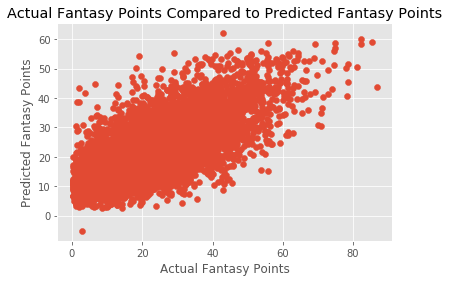

In [851]:
plt.scatter(y_test, ridgecv.predict(X_test_scale))
plt.xlabel('Actual Fantasy Points')
plt.ylabel('Predicted Fantasy Points')
plt.title("Actual Fantasy Points Compared to Predicted Fantasy Points")
plt.show()

#### KNN Regressor

#### Decision Tree Regressor

#### Random Forest Regressor

## Prediction

In [852]:
columns= ['Id', 'Nickname', 'Salary',  'Team', 'Opponent', 'Game', 'Injury Indicator']
fd = pd.read_csv(file, usecols=columns)

In [853]:
fd["Id"] = fd["Id"].str.split('-').str[1].astype(int)
fd = fd[fd['Injury Indicator'] != 'O']

In [854]:
fd['Opponent'] = np.where(fd['Opponent'] == "NY", "NYK", fd['Opponent'])
fd['Opponent'] = np.where(fd['Opponent'] == "NO", "NOP", fd['Opponent'])
fd['Opponent'] = np.where(fd['Opponent'] == "BKN", "BRK", fd['Opponent'])
fd['Opponent'] = np.where(fd['Opponent'] == "CHA", "CHO", fd['Opponent'])
fd['Opponent'] = np.where(fd['Opponent'] == "GS", "GSW", fd['Opponent'])
fd['Opponent'] = np.where(fd['Opponent'] == "SA", "SAS", fd['Opponent'])
fd['Team'] = np.where(fd['Team'] == "NY", "NYK", fd['Team'])
fd['Team'] = np.where(fd['Team'] == "NO", "NOP", fd['Team'])
fd['Team'] = np.where(fd['Team'] == "BKN", "BRK", fd['Team'])
fd['Team'] = np.where(fd['Team'] == "CHA", "CHO", fd['Team'])
fd['Team'] = np.where(fd['Team'] == "GS", "GSW", fd['Team'])
fd['Team'] = np.where(fd['Team'] == "SA", "SAS", fd['Team'])

#### Home/Away

In [855]:
home = fd['Game'].str.split("@", n = 1, expand = True)
fd['Away'] = home[0]
fd['Home'] = home[1]
fd['Home'] = np.where(fd['Home'] == "NY", "NYK", fd['Home'])
fd['Home'] = np.where(fd['Home'] == "NO", "NOP", fd['Home'])
fd['Home'] = np.where(fd['Home'] == "BKN", "BRK", fd['Home'])
fd['Home'] = np.where(fd['Home'] == "CHA", "CHO", fd['Home'])
fd['Home'] = np.where(fd['Home'] == "GS", "GSW", fd['Home'])
fd['Home'] = np.where(fd['Home'] == "SA", "SAS", fd['Home'])
fd['Away'] = np.where(fd['Away'] == "NY", "NYK", fd['Away'])
fd['Away'] = np.where(fd['Away'] == "NO", "NOP", fd['Away'])
fd['Away'] = np.where(fd['Away'] == "BKN", "BRK", fd['Away'])
fd['Away'] = np.where(fd['Away'] == "CHA", "CHO", fd['Away'])
fd['Away'] = np.where(fd['Away'] == "GS", "GSW", fd['Away'])
fd['Away'] = np.where(fd['Away'] == "SA", "SAS", fd['Away'])
fd['Home/Away'] = np.where(fd['Team'] == fd['Home'], 1, 0)
fd.drop(columns=['Game', 'Home', 'Away'], inplace=True)

In [856]:
fd.head(10)

,Id,Nickname,Salary,Team,Opponent,Injury Indicator,Home/Away
0,9644,James Harden,12600,HOU,LAL,NaN,0
1,40199,Giannis Antetokounmpo,12400,MIL,BOS,NaN,1
2,9488,LeBron James,11700,LAL,HOU,NaN,1
3,49111,Joel Embiid,11100,PHI,MIA,NaN,1
4,9646,Kevin Durant,10200,GSW,SAC,NaN,1
5,20848,Damian Lillard,10100,POR,BRK,NaN,0
6,14498,Kyrie Irving,9600,BOS,MIL,NaN,0
7,9524,Stephen Curry,9500,GSW,SAC,NaN,1
8,58312,D'Angelo Russell,9200,BRK,POR,NaN,1
9,66115,Ben Simmons,8700,PHI,MIA,NaN,1


In [857]:
fd.shape

(185, 7)

In [858]:
gamelogs.isnull().sum(axis=0)

Player             0
Age                3
Pos                0
Date               0
Tm                 0
Home/Away          0
Opp                0
GS                 0
MP                 0
TRB                0
AST                0
STL                0
BLK                0
TOV                0
PTS                0
Season             0
FPTS               0
log_FPTS           0
Game_Num           0
PV_MP           1032
PV_FPTS         1032
PV_GS           1032
PV_MP_2         2026
PV_FPTS_2       2026
AVG_FPTS        1032
Std_FPTS        2026
AVG_MP          1032
AVG_FPTS_3      3004
Std_FPTS_3      3004
AVG_MP_3        3004
AVG_FPTS_2      2026
Std_FPTS_2      2026
AVG_MP_2        2026
POS_AVG_FPTS      81
Opp_AVG_FPTS     805
Rest             137
After_Injury       0
Age_sq             3
dtype: int64

In [859]:
latest = gamelogs.loc[gamelogs.groupby('Player').Date.idxmax()]
latest.isnull().sum(axis=0)

Player            0
Age               1
Pos               0
Date              0
Tm                0
Home/Away         0
Opp               0
GS                0
MP                0
TRB               0
AST               0
STL               0
BLK               0
TOV               0
PTS               0
Season            0
FPTS              0
log_FPTS          0
Game_Num          0
PV_MP            30
PV_FPTS          30
PV_GS            30
PV_MP_2          45
PV_FPTS_2        45
AVG_FPTS         30
Std_FPTS         45
AVG_MP           30
AVG_FPTS_3       61
Std_FPTS_3       61
AVG_MP_3         61
AVG_FPTS_2       45
Std_FPTS_2       45
AVG_MP_2         45
POS_AVG_FPTS      0
Opp_AVG_FPTS      4
Rest            104
After_Injury      0
Age_sq            1
dtype: int64

In [860]:
latest = latest.loc[:, ['Player', 'Date', 'Game_Num','Pos', 'GS','MP', 'FPTS', 'Age','Age_sq','PV_FPTS', 'PV_FPTS_2', 
                        'Home/Away', 'PV_GS','AVG_FPTS', 'Std_FPTS', 'AVG_MP','AVG_FPTS_2', 'Std_FPTS_2', 'AVG_MP_2', 
                        'AVG_FPTS_3', 'Std_FPTS_3', 'AVG_MP_3', 'POS_AVG_FPTS', 'Opp_AVG_FPTS', 'Rest', 'After_Injury','PV_MP',
                        'PV_MP_2']]
latest = latest[latest.Date > '2018-05-01']
latest.drop(columns=['Home/Away'],inplace=True)

In [861]:
latest.isnull().sum(axis=0)

Player           0
Date             0
Game_Num         0
Pos              0
GS               0
MP               0
FPTS             0
Age              0
Age_sq           0
PV_FPTS         17
PV_FPTS_2       28
PV_GS           17
AVG_FPTS        17
Std_FPTS        28
AVG_MP          17
AVG_FPTS_2      28
Std_FPTS_2      28
AVG_MP_2        28
AVG_FPTS_3      33
Std_FPTS_3      33
AVG_MP_3        33
POS_AVG_FPTS     0
Opp_AVG_FPTS     1
Rest            54
After_Injury     0
PV_MP           17
PV_MP_2         28
dtype: int64

In [862]:
latest[latest['Date']==latest['Date'].max()].head()

,Player,Date,Game_Num,Pos,GS,MP,FPTS,Age,Age_sq,PV_FPTS,...,AVG_MP_2,AVG_FPTS_3,Std_FPTS_3,AVG_MP_3,POS_AVG_FPTS,Opp_AVG_FPTS,Rest,After_Injury,PV_MP,PV_MP_2
42160,Aaron Gordon,2019-02-14,52,F,1,32,30.2,23.413699,548.201284,34.8,...,29.5,26.366667,7.303652,29.333333,19.109322,20.742593,1.0,0,33.0,26.0
42162,Abdel Nader,2019-02-14,30,F,0,14,7.4,25.389041,644.603408,5.1,...,8.0,4.900000,3.404409,12.000000,19.109322,21.247414,2.0,0,12.0,4.0
42169,Alex Len,2019-02-14,53,C,0,24,24.7,25.665753,658.730899,11.9,...,15.5,18.900000,6.082763,14.000000,24.328814,28.635366,1.0,0,12.0,19.0
42174,Allonzo Trier,2019-02-14,50,G,0,19,6.2,23.076712,532.534652,26.8,...,22.0,15.333333,10.002666,22.666667,19.434746,22.537719,0.0,0,27.0,17.0
42175,Amile Jefferson,2019-02-14,5,F,0,5,3.2,25.775342,664.368279,5.6,...,3.5,3.666667,2.247962,3.333333,19.109322,20.742593,1.0,0,4.0,3.0


In [863]:
latest.columns

Index(['Player', 'Date', 'Game_Num', 'Pos', 'GS', 'MP', 'FPTS', 'Age',
       'Age_sq', 'PV_FPTS', 'PV_FPTS_2', 'PV_GS', 'AVG_FPTS', 'Std_FPTS',
       'AVG_MP', 'AVG_FPTS_2', 'Std_FPTS_2', 'AVG_MP_2', 'AVG_FPTS_3',
       'Std_FPTS_3', 'AVG_MP_3', 'POS_AVG_FPTS', 'Opp_AVG_FPTS', 'Rest',
       'After_Injury', 'PV_MP', 'PV_MP_2'],
      dtype='object')

In [864]:
latest.shape

(498, 27)

#### List of names that are close together

In [865]:
latest['Player'] = np.where(latest['Player'] == "Dennis Smith", "Dennis Smith Jr.", latest['Player'])
latest['Player'] = np.where(latest['Player'] == "Derrick Walton", "Derrick Walton Jr.", latest['Player'])
latest['Player'] = np.where(latest['Player'] == "Gary Payton", "Gary Payton II", latest['Player'])
latest['Player'] = np.where(latest['Player'] == "Glenn Robinson", "Glenn Robinson III", latest['Player'])
latest['Player'] = np.where(latest['Player'] == "James Ennis", "James Ennis III", latest['Player'])
latest['Player'] = np.where(latest['Player'] == "J.J. Redick", "JJ Redick", latest['Player'])
latest['Player'] = np.where(latest['Player'] == "J.R. Smith", "JR Smith", latest['Player'])
latest['Player'] = np.where(latest['Player'] == "Kelly Oubre", "Kelly Oubre Jr.", latest['Player'])
latest['Player'] = np.where(latest['Player'] == "Larry Nance", "Larry Nance Jr.", latest['Player'])
latest['Player'] = np.where(latest['Player'] == "Nene Hilario", "Nene", latest['Player'])
latest['Player'] = np.where(latest['Player'] == "Otto Porter", "Otto Porter Jr.", latest['Player'])
latest['Player'] = np.where(latest['Player'] == "Larry Nance", "Larry Nance Jr.", latest['Player'])
latest['Player'] = np.where(latest['Player'] == "P.J. Tucker", "PJ Tucker", latest['Player'])
latest['Player'] = np.where(latest['Player'] == 'Taurean Waller-Prince', 'Taurean Prince', latest['Player'])
latest['Player'] = np.where(latest['Player'] == 'Tim Hardaway', 'Tim Hardaway Jr.', latest['Player'])
latest['Player'] = np.where(latest['Player'] == "T.J. Leaf", "TJ Leaf", latest['Player'])
latest['Player'] = np.where(latest['Player'] == "T.J. Warren", "TJ Warren", latest['Player'])
latest['Player'] = np.where(latest['Player'] == "Wade Baldwin", "Wade Baldwin IV", latest['Player'])
latest['Player'] = np.where(latest['Player'] == "Wesley Iwundu", "Wes Iwundu", latest['Player'])

#### Merge

In [866]:
today = pd.merge(fd, latest, how='left', left_on='Nickname', right_on='Player')

In [867]:
today.shape

(185, 34)

### Variables for Prediction

#### Started Previous Game

In [868]:
today['PV_GS'] = today['GS']
today.drop(columns=['GS'], inplace=True)

#### Rest

In [869]:
today['Rest'] = (pd.to_datetime('today').date() - today['Date'].dt.date).dt.days - 1
today['Rest'] = np.where(today['Rest'] > 6, np.NaN, today['Rest'])
today['Rest'].fillna((today['Rest'].mean()), inplace=True)

In [870]:
today.head()

,Id,Nickname,Salary,Team,Opponent,Injury Indicator,Home/Away,Player,Date,Game_Num,...,AVG_MP_2,AVG_FPTS_3,Std_FPTS_3,AVG_MP_3,POS_AVG_FPTS,Opp_AVG_FPTS,Rest,After_Injury,PV_MP,PV_MP_2
0,9644,James Harden,12600,HOU,LAL,NaN,0,James Harden,2019-02-13,53.0,...,36.5,52.233333,8.612394,35.000000,19.415385,20.063636,5.0,0.0,36.0,37.0
1,40199,Giannis Antetokounmpo,12400,MIL,BOS,NaN,1,Giannis Antetokounmpo,2019-02-13,52.0,...,33.0,60.433333,4.400379,32.333333,26.659211,25.897917,5.0,0.0,35.0,31.0
2,9488,LeBron James,11700,LAL,HOU,NaN,1,LeBron James,2019-02-12,38.0,...,35.5,47.600000,16.333095,33.666667,26.600442,29.728261,6.0,0.0,33.0,38.0
3,49111,Joel Embiid,11100,PHI,MIA,NaN,1,Joel Embiid,2019-02-13,52.0,...,34.5,49.500000,8.265591,34.000000,24.311111,28.458750,5.0,0.0,37.0,32.0
4,9646,Kevin Durant,10200,GSW,SAC,NaN,1,Kevin Durant,2019-02-13,56.0,...,37.0,41.400000,10.558883,36.000000,26.659211,34.792000,5.0,0.0,37.0,37.0


#### Injury Status

In [871]:
today['After_Injury'] = np.where(today['Injury Indicator'] == 'GTD', 1, 0)
today.drop(columns=['Injury Indicator'], inplace=True)

#### Previous Game,  Last 2 Games, and Last 3 Games Stats (Average & Standard Deviation Fantasy Points, Average Minutes) 

In [872]:
today.drop(columns=['Std_FPTS_2', 'Std_FPTS_3'], inplace=True)

In [873]:
x = today.loc[:,['Player','FPTS','PV_FPTS']]
x['Std_FPTS_2'] = x.std(axis=1)
x.drop(columns=['FPTS','PV_FPTS'], inplace=True)
x.drop_duplicates(keep='first', inplace=True)
today = pd.merge(today, x, how='left', on='Player')

In [874]:
y = today.loc[:,['Player','FPTS','PV_FPTS', 'PV_FPTS_2']]
y['Std_FPTS_3'] = y.std(axis=1)
y.drop(columns=['FPTS','PV_FPTS', 'PV_FPTS_2'], inplace=True)
y.drop_duplicates(keep='first', inplace=True)
today = pd.merge(today, y, how='left', on='Player')

In [875]:
today['AVG_FPTS_3'] = (today['FPTS'] + today['PV_FPTS'] + today['PV_FPTS_2'])/3
today['AVG_FPTS_2'] = (today['FPTS'] + today['PV_FPTS'])/2
today['PV_FPTS'] = today['FPTS']
today.drop(columns=['FPTS'], inplace=True)

In [876]:
today['AVG_MP_3'] = (today['MP'] + today['PV_MP'] + today['PV_MP_2'])/3
today['AVG_MP_2'] = (today['MP'] + today['PV_MP'])/2
today['PV_MP'] = today['MP']
today.drop(columns=['MP'], inplace=True)

#### Position Average

In [877]:
Pos_avg = gamelogs.loc[:,['Pos','Date', 'POS_AVG_FPTS']]
Pos_avg = Pos_avg[Pos_avg['Date']==Pos_avg['Date'].max()]
Pos_avg.drop(columns=['Date'], inplace=True)
Pos_avg.drop_duplicates(keep='first', inplace=True)

In [878]:
today.drop(columns=['POS_AVG_FPTS'], inplace=True)
today_x = pd.merge(today, Pos_avg, how='left', on=['Pos'])
today = today_x

#### Opponent Average by Position

In [879]:
Opp_avg = gamelogs.loc[:,['Pos','Opp','Date', 'Opp_AVG_FPTS']]
Opp_avg.sort_values(by=['Opp', 'Date'], ascending=False, inplace=True)
Opp_avg.drop(columns=['Date'], inplace=True)
Opp_avg.drop_duplicates(subset=['Pos','Opp'], keep='first', inplace=True)

In [880]:
Opp_avg.shape

(220, 3)

In [881]:
today.drop(columns=['Opp_AVG_FPTS'], inplace=True)
today_y = pd.merge(today, Opp_avg, how='left', left_on=['Pos','Opponent'], right_on=['Pos', 'Opp'])
today = today_y

#### Validation

In [882]:
today.columns

Index(['Id', 'Nickname', 'Salary', 'Team', 'Opponent', 'Home/Away', 'Player',
       'Date', 'Game_Num', 'Pos', 'Age', 'Age_sq', 'PV_FPTS', 'PV_FPTS_2',
       'PV_GS', 'AVG_FPTS', 'Std_FPTS', 'AVG_MP', 'AVG_FPTS_2', 'AVG_MP_2',
       'AVG_FPTS_3', 'AVG_MP_3', 'Rest', 'After_Injury', 'PV_MP', 'PV_MP_2',
       'Std_FPTS_2', 'Std_FPTS_3', 'POS_AVG_FPTS', 'Opp', 'Opp_AVG_FPTS'],
      dtype='object')

In [883]:
today = today.reindex(columns=['Player','Age', 'Age_sq','PV_FPTS', 'PV_MP','Home/Away',
                         'PV_GS', 'AVG_FPTS', 'Std_FPTS', 'Std_FPTS_2',
                         'AVG_FPTS_3', 'Std_FPTS_3', 'AVG_MP_3', 'POS_AVG_FPTS', 'Opp_AVG_FPTS', 'Rest', 'After_Injury'])

# 'PV_FPTS_2', 'PV_MP_2', 'AVG_FPTS_2', 'AVG_MP_2','AVG_MP',

In [884]:
today.head()

,Player,Age,Age_sq,PV_FPTS,PV_MP,Home/Away,PV_GS,AVG_FPTS,Std_FPTS,Std_FPTS_2,AVG_FPTS_3,Std_FPTS_3,AVG_MP_3,POS_AVG_FPTS,Opp_AVG_FPTS,Rest,After_Injury
0,James Harden,29.468493,868.392089,51.0,40.0,0,1.0,59.994231,14.966019,7.141778,52.000000,8.643495,37.666667,19.434746,19.803636,5.0,0
1,Giannis Antetokounmpo,24.189041,585.109709,79.3,38.0,1,1.0,56.135294,11.237950,10.535891,66.466667,11.934963,34.666667,26.684348,25.004348,5.0,0
2,LeBron James,34.120548,1164.211792,75.2,43.0,1,1.0,50.656757,12.486494,25.243712,60.366667,18.599014,38.000000,26.684348,27.147059,6.0,0
3,Joel Embiid,24.915068,620.760638,46.3,34.0,1,1.0,53.117647,11.496707,1.414214,50.966667,6.429101,34.333333,24.328814,23.191892,5.0,0
4,Kevin Durant,30.375342,922.661430,47.8,33.0,1,1.0,47.405455,11.697316,4.879037,46.966667,5.695905,35.666667,26.684348,34.014286,5.0,0


In [885]:
today = today.dropna()

In [886]:
today.isnull().sum(axis=0)

Player          0
Age             0
Age_sq          0
PV_FPTS         0
PV_MP           0
Home/Away       0
PV_GS           0
AVG_FPTS        0
Std_FPTS        0
Std_FPTS_2      0
AVG_FPTS_3      0
Std_FPTS_3      0
AVG_MP_3        0
POS_AVG_FPTS    0
Opp_AVG_FPTS    0
Rest            0
After_Injury    0
dtype: int64

In [887]:
today.shape

(167, 17)

In [888]:
today.columns

Index(['Player', 'Age', 'Age_sq', 'PV_FPTS', 'PV_MP', 'Home/Away', 'PV_GS',
       'AVG_FPTS', 'Std_FPTS', 'Std_FPTS_2', 'AVG_FPTS_3', 'Std_FPTS_3',
       'AVG_MP_3', 'POS_AVG_FPTS', 'Opp_AVG_FPTS', 'Rest', 'After_Injury'],
      dtype='object')

In [889]:
print(lin_reg.predict(today.iloc[:,1:17]).sum(),'\n',lassocv.predict(today.iloc[:,1:17]).sum(),'\n', 
      ridgecv.predict(today.iloc[:,1:17]).sum())

81931.0367498363 
 38028.658665417446 
 77929.553547015


In [890]:
today['Prediction'] = lassocv.predict(today.iloc[:,1:17])/10

#today['real_prediction'] = y_scaler.transform(today['Prediction'].values.reshape(-1,1))

In [891]:
today.head()

,Player,Age,Age_sq,PV_FPTS,PV_MP,Home/Away,PV_GS,AVG_FPTS,Std_FPTS,Std_FPTS_2,AVG_FPTS_3,Std_FPTS_3,AVG_MP_3,POS_AVG_FPTS,Opp_AVG_FPTS,Rest,After_Injury,Prediction
0,James Harden,29.468493,868.392089,51.0,40.0,0,1.0,59.994231,14.966019,7.141778,52.000000,8.643495,37.666667,19.434746,19.803636,5.0,0,58.198687
1,Giannis Antetokounmpo,24.189041,585.109709,79.3,38.0,1,1.0,56.135294,11.237950,10.535891,66.466667,11.934963,34.666667,26.684348,25.004348,5.0,0,59.131721
2,LeBron James,34.120548,1164.211792,75.2,43.0,1,1.0,50.656757,12.486494,25.243712,60.366667,18.599014,38.000000,26.684348,27.147059,6.0,0,54.177150
3,Joel Embiid,24.915068,620.760638,46.3,34.0,1,1.0,53.117647,11.496707,1.414214,50.966667,6.429101,34.333333,24.328814,23.191892,5.0,0,52.924335
4,Kevin Durant,30.375342,922.661430,47.8,33.0,1,1.0,47.405455,11.697316,4.879037,46.966667,5.695905,35.666667,26.684348,34.014286,5.0,0,48.131287


In [892]:
today['Prediction'].describe()

count    167.000000
mean      22.771652
std       10.886720
min        5.396175
25%       14.456986
50%       20.764353
75%       29.655128
max       59.131721
Name: Prediction, dtype: float64

In [893]:
today[today['PV_FPTS']==0]

,Player,Age,Age_sq,PV_FPTS,PV_MP,Home/Away,PV_GS,AVG_FPTS,Std_FPTS,Std_FPTS_2,AVG_FPTS_3,Std_FPTS_3,AVG_MP_3,POS_AVG_FPTS,Opp_AVG_FPTS,Rest,After_Injury,Prediction


In [894]:
corr_1 = today.corr()
corr_1.style.background_gradient().set_precision(2)

,Age,Age_sq,PV_FPTS,PV_MP,Home/Away,PV_GS,AVG_FPTS,Std_FPTS,Std_FPTS_2,AVG_FPTS_3,Std_FPTS_3,AVG_MP_3,POS_AVG_FPTS,Opp_AVG_FPTS,Rest,After_Injury,Prediction
Age,1,1,0.14,0.089,0.018,-0.047,0.13,0.098,0.12,0.12,0.17,0.095,0.13,0.15,0.056,-0.045,0.12
Age_sq,1,1,0.13,0.076,0.016,-0.057,0.11,0.078,0.13,0.11,0.17,0.081,0.13,0.16,0.064,-0.04,0.11
PV_FPTS,0.14,0.13,1,0.82,0.064,0.48,0.73,0.45,0.34,0.89,0.37,0.75,0.24,0.051,-0.0057,-0.17,0.81
PV_MP,0.089,0.076,0.82,1,0.061,0.56,0.63,0.41,0.26,0.8,0.29,0.89,0.08,-0.064,-0.021,-0.17,0.73
Home/Away,0.018,0.016,0.064,0.061,1,-0.037,-0.025,-0.1,-0.022,0.012,-0.0095,0.005,-0.079,-0.059,0.25,0.085,-0.0094
PV_GS,-0.047,-0.057,0.48,0.56,-0.037,1,0.64,0.4,0.15,0.62,0.17,0.69,0.21,0.076,-0.01,0.04,0.66
AVG_FPTS,0.13,0.11,0.73,0.63,-0.025,0.64,1,0.72,0.3,0.88,0.34,0.76,0.29,0.11,-0.00023,0.0055,0.99
Std_FPTS,0.098,0.078,0.45,0.41,-0.1,0.4,0.72,1,0.36,0.59,0.44,0.53,0.24,0.057,-0.036,0.15,0.69
Std_FPTS_2,0.12,0.13,0.34,0.26,-0.022,0.15,0.3,0.36,1,0.34,0.72,0.3,0.1,0.033,0.14,0.055,0.32
AVG_FPTS_3,0.12,0.11,0.89,0.8,0.012,0.62,0.88,0.59,0.34,1,0.42,0.87,0.26,0.056,0.03,-0.095,0.95


## Generate Lineup

#### Data in Right Format

In [895]:
opt = today.loc[:,['Player', 'Prediction']]

In [896]:
fd_opt = pd.read_csv(file)

In [897]:
fd_opt = pd.merge(fd_opt, today, how='left', left_on='Nickname', right_on='Player')
fd_opt['FPPG'] = fd_opt['Prediction'].astype(str)

In [898]:
fd_opt = fd_opt[fd_opt['Nickname']!='Carmelo Anthony']

In [899]:
fd_opt.drop_duplicates(subset=['Player','Prediction'], keep=False, inplace=True)

In [900]:
fd_opt.drop(columns=['Player', 'Prediction'],inplace=True)

In [901]:
fd_opt.shape

(167, 30)

In [902]:
fd_opt.to_csv("lineup.csv")

#### Set Lineup

In [903]:
optimizer = get_optimizer(Site.FANDUEL, Sport.BASKETBALL)

In [904]:
optimizer.load_players_from_CSV("lineup.csv")

In [905]:
# Barea GTD
#barea = optimizer.get_player_by_name('J.J. Barea')
#barea.max_exposure = 0.0

# Jamal Crawford
#korver = optimizer.get_player_by_name('Jamal Crawford')
#korver.max_exposure = 0.0

# Parker
#parker = optimizer.get_player_by_name('Rudy Gay')
#parker.max_exposure = 0.0

# Dirk GTD
#dirk = optimizer.get_player_by_name('Dirk Nowitzki')
#dirk.max_exposure = 0.0

# Pau
#pau = optimizer.get_player_by_name('Pau Gasol')
#pau.max_exposure = 0.0

# Millsap
#millsap = optimizer.get_player_by_name('Millsap')
#millsap.max_exposure = 0.0

In [906]:
k = 5
exposure = k/k
random = False

for lineup in optimizer.optimize(n=k, max_exposure = exposure, randomness=random):
    print(lineup)

 1. PG    Chris Paul                    PG    HOU            39.675  7800.0$   
 2. PG    De'Aaron Fox                  PG    SAC            36.939  7000.0$   
 3. SG    Khris Middleton               SG    MIL            33.654  6400.0$   
 4. SG    Caris LeVert                  SG    BKN            31.839  5800.0$   
 5. SF    Josh Richardson               SF    MIA            33.077  6300.0$   
 6. SF    Nemanja Bjelica               SF    SAC            24.577  4200.0$   
 7. PF    Tobias Harris                 PF    PHI            36.891  7100.0$   
 8. PF    Bam Adebayo                   PF    MIA            24.33   4300.0$   
 9. C     Joel Embiid                   C     PHI            52.924  11100.0$  

Fantasy Points 313.906
Salary 60000.0
 1. PG    Chris Paul                    PG    HOU            39.675  7800.0$   
 2. PG    De'Aaron Fox                  PG    SAC            36.939  7000.0$   
 3. SG    Buddy Hield                   SG    SAC            33.461  6300.0$   
 